<a href="https://colab.research.google.com/github/Vinmsh25/Using-Whale-Optimizer-to-Forecast-Recurrence-in-Well-Differentiated-Thyroid-Cancer/blob/main/woa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iteration 1/100
✅ New best loss: 0.0887 | Accuracy: 95.45%

Iteration 2/100
✅ New best loss: 0.0412 | Accuracy: 97.73%

Iteration 3/100
✅ New best loss: 0.0200 | Accuracy: 98.86%

Iteration 4/100
✅ New best loss: 0.0108 | Accuracy: 100.00%

Iteration 5/100
✅ New best loss: 0.0080 | Accuracy: 100.00%

Iteration 6/100
✅ New best loss: 0.0050 | Accuracy: 100.00%

Iteration 7/100
✅ New best loss: 0.0050 | Accuracy: 100.00%

Iteration 8/100
✅ New best loss: 0.0041 | Accuracy: 100.00%

Iteration 9/100
✅ New best loss: 0.0032 | Accuracy: 100.00%

Iteration 10/100
✅ New best loss: 0.0026 | Accuracy: 100.00%

Iteration 11/100
✅ New best loss: 0.0024 | Accuracy: 100.00%

Iteration 12/100
✅ New best loss: 0.0023 | Accuracy: 100.00%

Iteration 13/100
✅ New best loss: 0.0019 | Accuracy: 100.00%

Iteration 14/100
✅ New best loss: 0.0025 | Accuracy: 100.00%

Iteration 15/100
✅ New best loss: 0.0014 | Accuracy: 100.00%

Iteration 16/100
✅ New best loss: 0.0014 | Accuracy: 100.00%

Iteration 17/100
✅ N

Exception ignored in: <function AtomicFunction.__del__ at 0x7cc48b72a0c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py", line 302, in __del__
    self._bound_context.remove_function(self.name)
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/context.py", line 1663, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
KeyboardInterrupt: 


Iteration 67/100
✅ New best loss: 0.0006 | Accuracy: 100.00%

Iteration 68/100
✅ New best loss: 0.0010 | Accuracy: 100.00%

Iteration 69/100
✅ New best loss: 0.0008 | Accuracy: 100.00%

Iteration 70/100
✅ New best loss: 0.0007 | Accuracy: 100.00%

Iteration 71/100
✅ New best loss: 0.0013 | Accuracy: 100.00%

Iteration 72/100
✅ New best loss: 0.0008 | Accuracy: 100.00%

Iteration 73/100
✅ New best loss: 0.0007 | Accuracy: 100.00%

Iteration 74/100
✅ New best loss: 0.0007 | Accuracy: 100.00%

Iteration 75/100
✅ New best loss: 0.0021 | Accuracy: 100.00%

Iteration 76/100
✅ New best loss: 0.0008 | Accuracy: 100.00%

Iteration 77/100
✅ New best loss: 0.0011 | Accuracy: 100.00%

Iteration 78/100
✅ New best loss: 0.0008 | Accuracy: 100.00%

Iteration 79/100
✅ New best loss: 0.0007 | Accuracy: 100.00%

Iteration 80/100
✅ New best loss: 0.0009 | Accuracy: 100.00%

Iteration 81/100
✅ New best loss: 0.0007 | Accuracy: 100.00%

Iteration 82/100
✅ New best loss: 0.0008 | Accuracy: 100.00%

Iteratio

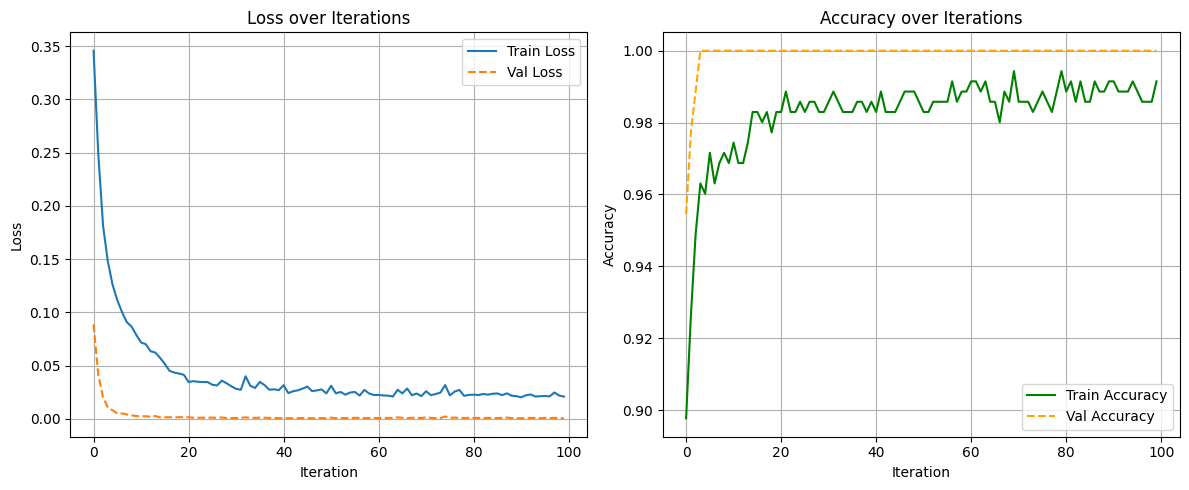

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LeakyReLU

# Reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Load and preprocess data
df = pd.read_csv("Thyroid_Diff.csv")
df = df[['Age', 'Smoking', 'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Recurred']]
df = pd.get_dummies(df, drop_first=True)

X = df.drop('Recurred_Yes', axis=1)
y = df['Recurred_Yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

smote = SMOTE(random_state=seed)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed, stratify=y_train)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Helper functions
def create_ann(weights=None):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(256),
        LeakyReLU(0.01),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    if weights is not None:
        model.set_weights(weights)
    return model

def flatten_weights(weights):
    return np.concatenate([w.flatten() for w in weights])

def reshape_weights(flat_weights, shapes):
    weights = []
    idx = 0
    for shape in shapes:
        size = np.prod(shape)
        weights.append(flat_weights[idx:idx+size].reshape(shape))
        idx += size
    return weights

def get_weight_shapes(model):
    return [w.shape for w in model.get_weights()]

def fitness_function(flat_weights, model_template, shapes, X, y):
    weights = reshape_weights(flat_weights, shapes)
    model = create_ann(weights)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    loss, _ = model.evaluate(X, y, verbose=0)
    return loss

# Enhanced WOA

def enhanced_woa(X_train, y_train, X_val, y_val, model_template, shapes, pop_size=10, max_iter=100):
    dim = len(flatten_weights(model_template.get_weights()))
    lb, ub = -1, 1
    population = np.random.uniform(lb, ub, (pop_size, dim))
    fitness = [fitness_function(ind, model_template, shapes, X_train, y_train) for ind in population]

    best_idx = np.argmin(fitness)
    best_sol = population[best_idx].copy()
    best_fit = fitness[best_idx]

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for t in range(max_iter):
        a = 2 - t * (2 / max_iter)
        for i in range(pop_size):
            r1 = np.random.rand()
            A = 2 * a * r1 - a
            C = 2 * np.random.rand()
            p = np.random.rand()
            b = 1
            l = np.random.uniform(-1, 1)

            if p < 0.5:
                if abs(A) < 1:
                    D = abs(C * best_sol - population[i])
                    new_pos = best_sol - A * D
                else:
                    rand_idx = np.random.randint(pop_size)
                    D = abs(C * population[rand_idx] - population[i])
                    new_pos = population[rand_idx] - A * D
            else:
                D = abs(best_sol - population[i])
                new_pos = D * np.exp(b * l) * np.cos(2 * np.pi * l) + best_sol

            new_pos = np.clip(new_pos, lb, ub)
            new_fit = fitness_function(new_pos, model_template, shapes, X_train, y_train)

            if new_fit < fitness[i]:
                population[i] = new_pos
                fitness[i] = new_fit

            if new_fit < best_fit:
                best_sol = new_pos.copy()
                best_fit = new_fit

        # Local search
        best_weights = reshape_weights(best_sol, shapes)
        best_model = create_ann(best_weights)
        best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        best_model.fit(X_train, y_train, epochs=3, batch_size=32, verbose=0)
        best_sol = flatten_weights(best_model.get_weights())
        best_fit = fitness_function(best_sol, model_template, shapes, X_train, y_train)

        # Evaluation for logging
        model_eval = create_ann(reshape_weights(best_sol, shapes))
        model_eval.compile(loss='binary_crossentropy', metrics=['accuracy'])
        train_loss, train_acc = model_eval.evaluate(X_train, y_train, verbose=0)
        val_loss, val_acc = model_eval.evaluate(X_val, y_val, verbose=0)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Iteration {t+1}/{max_iter}")
        print(f"✅ New best loss: {val_loss:.4f} | Accuracy: {val_acc * 100:.2f}%\n")

    return best_sol, history

# Run E-WOA
model_template = create_ann()
shapes = get_weight_shapes(model_template)
best_weights_flat, history = enhanced_woa(X_train, y_train, X_val, y_val, model_template, shapes)

# Final model
final_weights = reshape_weights(best_weights_flat, shapes)
final_model = create_ann(final_weights)
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
final_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Evaluate
loss, acc = final_model.evaluate(X_test, y_test)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {acc * 100:.2f}%")

# Classification report
y_pred = (final_model.predict(X_test) > 0.5).astype(int)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss', linestyle='--')
plt.title('Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy', color='green')
plt.plot(history['val_acc'], label='Val Accuracy', color='orange', linestyle='--')
plt.title('Accuracy over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

ValueError: shapes (77,20) and (10,10) not aligned: 20 (dim 1) != 10 (dim 0)